#Tensorflow Object Detection with custom dataset in Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com) using [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Requirements are only dataset images and annotations file.**

The code is compatible with Object Detection api updates in Sep 17 2018 [release](https://github.com/tensorflow/models/tree/master/research/object_detection#Sep-17-2018).

**Colab Runtime type: Python3, GPU enabled.**



#Create Dataset

I generated dataset annotations with [LabelImg](https://github.com/tzutalin/labelImg).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:

1.   Collect various pictures of objects to detect (for ssd_mobilenet_v1_coco better use squarefles with similar (not big and not small dimensions))
2.   In LabelImg create annotation files. LabelImg saves annotations as XML files in PASCAL VOC format
3.   After creating annotation files in LabelImg separate all the jpg and xml files in two part - train (about 80%) and test (about 20%) and copy it and save it to train and test directories.
4.   Prepare object_detection.pbtxt file. it must have same amount of classes like predefined_classas.txt file from labelImg.
example for insulators
```
item {
  id: 1
  name: 'insulator'
}
```
Directories structure of zip file
```
   |data_insulators
       |data
         test_labels.csv
         test_record
         train_labels.csv
         train.record
         object_detection.pbtxt
       |images  
         |train
            <train files *.jpg and *.xml files (80%) of all files>
         |test
            <test files *.jpg and *.xml files (20%) of all files>
        generate_tfrecord.py
        xml_to_csv.py
```




# Install required packages
content - base directory for Google colab

In [1]:
%cd /content

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 matplotlib PyDrive
#!pip install -q pycocotools
!git clone https://github.com/tensorflow/models.git
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
!cp -r pycocotools /content/models/research/

%cd /content/models/research
#!protoc object_detection/protos/*.proto --python_out=.
!protoc object_detection/protos/anchor_generator.proto --python_out=.
!protoc object_detection/protos/argmax_matcher.proto --python_out=.
!protoc object_detection/protos/bipartite_matcher.proto --python_out=.
!protoc object_detection/protos/box_coder.proto --python_out=.
!protoc object_detection/protos/box_predictor.proto --python_out=.
!protoc object_detection/protos/eval.proto --python_out=.
!protoc object_detection/protos/faster_rcnn.proto --python_out=.
!protoc object_detection/protos/faster_rcnn_box_coder.proto --python_out=.
!protoc object_detection/protos/graph_rewriter.proto --python_out=.
!protoc object_detection/protos/grid_anchor_generator.proto --python_out=.
!protoc object_detection/protos/hyperparams.proto --python_out=.
!protoc object_detection/protos/image_resizer.proto --python_out=.
!protoc object_detection/protos/input_reader.proto --python_out=.
!protoc object_detection/protos/keypoint_box_coder.proto --python_out=.
!protoc object_detection/protos/losses.proto --python_out=.
!protoc object_detection/protos/matcher.proto --python_out=.
!protoc object_detection/protos/mean_stddev_box_coder.proto --python_out=.
!protoc object_detection/protos/model.proto --python_out=.
!protoc object_detection/protos/multiscale_anchor_generator.proto --python_out=.
!protoc object_detection/protos/optimizer.proto --python_out=.
!protoc object_detection/protos/pipeline.proto --python_out=.
!protoc object_detection/protos/post_processing.proto --python_out=.
!protoc object_detection/protos/preprocessor.proto --python_out=.
!protoc object_detection/protos/region_similarity_calculator.proto --python_out=.
!protoc object_detection/protos/square_box_coder.proto --python_out=.
!protoc object_detection/protos/ssd.proto --python_out=.
!protoc object_detection/protos/ssd_anchor_generator.proto --python_out=.
!protoc object_detection/protos/string_int_label_map.proto --python_out=.
!protoc object_detection/protos/train.proto --python_out=.

#%cd /content/models/research

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
    100% |████████████████████████████████| 993kB 20.6MB/s 
Cloning into 'models'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 24299 (delta 35), reused 15 (delta 6), pack-reused 24242
Receiving objects: 100% (24299/24299), 563.39 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (14383/14383), done.
Checking out files: 100% (2768/2768), done.
Cloning into 'cocoapi'...
remote: Enumerating objects: 947, done.
remote: Total 947 (delta 0), reused 0 (delta 0), pack-reused 947
Receiving objects: 100% (947/947), 11.69 MiB | 6.27 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/content/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a

# Download and extract dataset


*   Change name attribute in label_map, accordingly with objectclass filename.
*   Substitute fileId value with your dataset.zip id in Google Drive. See [here](https://stackoverflow.com/a/48855034/9250875) my answer to get file id.

In [30]:
%cd /content
%mkdir data_insulators
%cd /content/data_insulators


#!echo "item {\n id: 1\n name: 'dog'\n}" > label_map.pbtxt

# shared fileid link for googledrive
fileId = '1H_rAz9YRcP96UYVEW5Ta7azcLReMnNPG'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/content
/content/data_insulators
Extracted zip file 1H_rAz9YRcP96UYVEW5Ta7azcLReMnNPG.zip


after that You heave recieved new data_insulators directory in content directory with all the files

#Preparing files for trains and tests
Airst we need to create train_labels.csv and test_labels.csv files

code of program for csv files preparing is from xml_to_csv.py file - it can be executed directly form command line or from python notebook execution code




In [31]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
	for directory in ['train','test']:
		image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory))
		xml_df = xml_to_csv(image_path)
		xml_df.to_csv('data/{}_labels.csv'.format(directory), index=None)
		print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.
Successfully converted xml to csv.


After this procedure we have two new file in data directory - test_labels.csv and train_labels.csv

# Create TFRecord

execute generate_tfrecord.py code 

In [32]:
%cd /content/data_insulators

!python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=data/train.record --image_dir=images/train

!python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=data/test.record --image_dir=images/test

/content/data_insulators
data/train.record
images/train
Successfully created the TFRecords: /content/data_insulators/data/train.record
data/test.record
images/test
Successfully created the TFRecords: /content/data_insulators/data/test.record


# Download pretrained model

Download **ssd_mobilenet_v1_coco** model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [55]:
%cd /content/data_insulators
%rm -rf models


/content/data_insulators


In [56]:
%mkdir /content/data_insulators/models
%cd /content/data_insulators/models

import os
import shutil
import glob
import urllib.request
import tarfile

MODEL = 'ssd_mobilenet_v1_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'ssd_mobilenet_v1_coco'

#if not (os.path.exists(MODEL_FILE)):
#  opener = urllib.request.URLopener()
#  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

with urllib.request.urlopen(DOWNLOAD_BASE+MODEL_FILE) as response, open(MODEL_FILE, 'wb') as out_file:
  shutil.copyfileobj(response, out_file)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/data_insulators/models


# Edit model config file
To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.


In [57]:
%cd /content

import re

filename = '/content/data_insulators/models/ssd_mobilenet_v1_coco/pipeline.config'
#filename = '/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('num_classes: 90', 'num_classes: 1', s)
  s = re.sub('batch_size: 24', 'batch_size: 24', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/data_insulators/models/ssd_mobilenet_v1_coco/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record', '/content/data_insulators/data/train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record', '/content/data_insulators/data/test.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/data_insulators/data/object-detection.pbtxt', s)
  f.write(s)


/content


# Train model
Make and set train directory num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [58]:
%cd /content
%mkdir train_dir

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/data_insulators/models/ssd_mobilenet_v1_coco/pipeline.config \
    --model_dir=/content/train_dir \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500


/content
mkdir: cannot create directory ‘train_dir’: File exists
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
2019-02-01 09:07:08.660422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-01 09:07:08.660935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2019-02-01 09:07:08.660972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-02-01 09:07:09.553989: I ten

#Tensorboard visualisation

In [59]:
%cd /content/train_dir

LOG_DIR = '/content/train_dir'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt

/content/train_dir
/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
added 54 packages from 32 contributors in 2.43s


link for Tenorboard located in /content/train_dir/cat.txt file

#Export trained model

Export trained model with highest step number in filename.

In [61]:
%cd /content

lst = os.listdir('train_dir')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/data_insulators/models/ssd_mobilenet_v1_coco/pipeline.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=train_dir/$last_model



/content
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
114 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account

#Upload jpg image for inference

In [72]:
%cd /content

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/content


Saving image1.jpg to image1.jpg
saved file image1.jpg


# Run inference


/content/models/research/object_detection


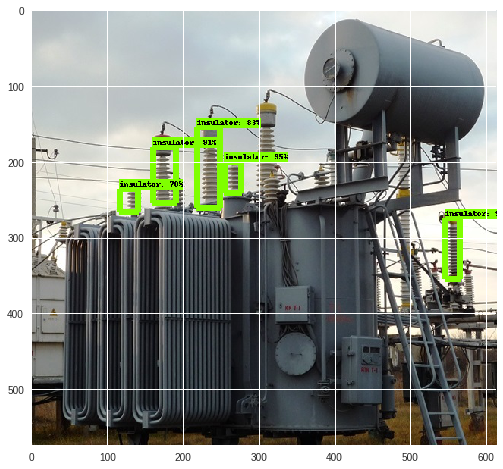

In [73]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
#  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  
  
# This is needed to display the images.
%matplotlib inline


from utils import label_map_util

from utils import visualization_utils as vis_util


# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/data_insulators/data/', 'object-detection.pbtxt')

NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
     
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)



def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)



# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  